<a href="https://colab.research.google.com/github/zkibnksmh/MachineLearningTasks/blob/main/UASML/Exercise_06_PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Zaky Ibnu Kusumah
#1103204213
#TK4404

## **06. PyTorch Transfer Learning Exercise Solutions**

**1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.**

In [ ]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1078 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 32.79 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


## Analisis Kode:

**Impor Pustaka/Modul:**
Langkah pertama melibatkan impor pustaka kunci seperti PyTorch, torchvision, NumPy, dan Matplotlib. Pustaka-pustaka ini diperlukan untuk membangun dan mengembangkan model deep learning di lingkungan Google Colab.

**Instalasi torchinfo:**
Langkah berikutnya adalah memeriksa ketersediaan modul torchinfo dan menginstalnya menggunakan pip jika tidak ditemukan. Ini memastikan bahwa fungsionalitas tambahan yang diperlukan untuk memberikan informasi tentang model PyTorch dapat diakses.

**Impor going_modular Scripts:**
Langkah ini berusaha mengimpor skrip data_setup dan engine dari paket going_modular. Jika impor gagal, sistem akan secara otomatis mengunduh repositori dari GitHub, memindahkan skrip ke direktori yang sesuai di lingkungan Google Colab, dan membersihkan sumber daya yang diunduh.

**Kesimpulan:**
Kode ini menyediakan serangkaian langkah-langkah yang komprehensif di lingkungan Google Colab untuk memastikan konfigurasi yang tepat dan memperoleh skrip yang diperlukan untuk pengembangan model deep learning menggunakan PyTorch. Tindakan ini diambil untuk memastikan kelancaran pengembangan model dan menanggulangi ketergantungan yang mungkin tidak tersedia secara lokal di lingkungan Colab.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

## Penjelasan Kode:

Kode ini bertujuan untuk menentukan perangkat (device) yang akan digunakan untuk eksekusi operasi oleh PyTorch. Berikut adalah penjelasan lebih rinci:

```python
device = "cuda" if torch.cuda.is_available() else "cpu"


**Get Data**

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## Impor Pustaka dan Modul:

Kode dimulai dengan mengimpor pustaka dan modul yang diperlukan, termasuk `os` untuk operasi sistem, `requests` untuk mengunduh data dari internet, `zipfile` untuk menangani file ZIP, dan `Path` untuk bekerja dengan jalur file.

## Atur Jalur ke Folder Data:

Script menetapkan jalur ke folder data dan subfolder khusus bernama "pizza_steak_sushi."

## Periksa dan Persiapkan Folder Dataset:

Dilakukan pemeriksaan kondisional untuk memastikan keberadaan folder dataset "pizza_steak_sushi." Jika belum ada, script akan membuat folder tersebut.

## Unduh dan Persiapkan Dataset:

Kode melanjutkan dengan mengunduh file ZIP yang berisi dataset "pizza_steak_sushi" dari repositori GitHub. Selanjutnya, konten ZIP diekstrak ke dalam folder dataset yang telah dibuat sebelumnya. Setelah ekstraksi berhasil, file ZIP dihapus untuk menjaga struktur direktori yang bersih.

## Atur Direktori:

Terakhir, script menetapkan jalur untuk direktori "train" dan "test" di dalam folder dataset "pizza_steak_sushi." Direktori ini akan digunakan untuk menyimpan data pelatihan dan pengujian masing-masing.


**Prepare data**

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d69ba346e30>,
 ['pizza', 'steak', 'sushi'])

## Pembuatan Pipeline Transformasi:

### Pipeline Transformasi:
Dalam penulisan ini, sebuah pipeline transformasi dibangun untuk memproses dan menyiapkan data set. Transformasi yang diterapkan adalah sebagai berikut:

```python
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 1. Mengubah ukuran semua gambar menjadi 224x224 (meskipun beberapa model mungkin memerlukan ukuran yang berbeda)
    transforms.ToTensor(),  # 2. Mengubah nilai piksel gambar menjadi rentang antara 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 3. Rerata [0.485, 0.456, 0.406] (melintasi setiap saluran warna)
                         std=[0.229, 0.224, 0.225])  # 4. Deviasi standar [0.229, 0.224, 0.225] (melintasi setiap saluran warna),
])


**Get and prepare a pretrained model**

In [ ]:
import torch
import torchvision
from torch import nn

# Setup the model with pretrained weights and send it to the target device
model_0 = torch.hub.load('rwightman/pytorch-image-models', 'efficientnet_b0', pretrained=True).to(device)

# Freeze all base layers by setting requires_grad=False
for param in model_0.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=model_0.num_features,
              out_features=output_shape,  # same number of output units as our number of classes
              bias=True)).to(device)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/pytorch-image-models/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hug

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

## Pembaruan Kode untuk Model EfficientNet B0

Dalam memperbarui kode untuk menggunakan model EfficientNet B0, terdapat beberapa penyesuaian yang perlu dilakukan. Hal ini disebabkan oleh perbedaan struktur model saat diunduh langsung dari repositori.

### 1. Mengunduh Model dan Penyesuaian Parameter

```python
import torch
import torchvision
from torch import nn

# Setup the model with pretrained weights and send it to the target device
model_0 = torch.hub.load('rwightman/pytorch-image-models', 'efficientnet_b0', pretrained=True).to(device)


**Train Model**

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)


In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1013 | train_acc: 0.3906 | test_loss: 0.9095 | test_acc: 0.5189
Epoch: 2 | train_loss: 0.8563 | train_acc: 0.7852 | test_loss: 0.8102 | test_acc: 0.7131
Epoch: 3 | train_loss: 0.8211 | train_acc: 0.7383 | test_loss: 0.7335 | test_acc: 0.7850
Epoch: 4 | train_loss: 0.7298 | train_acc: 0.7734 | test_loss: 0.6182 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6194 | train_acc: 0.7734 | test_loss: 0.5883 | test_acc: 0.8968
[INFO] Total training time: 155.691 seconds


## Penjelasan Implementasi Pelatihan Model dengan PyTorch

Pada potongan kode ini, kita fokus pada pelatihan model menggunakan PyTorch untuk tugas klasifikasi. Fungsi kerugian yang kita gunakan adalah `nn.CrossEntropyLoss`. Alasan kita memilih ini karena cocok untuk output model yang memiliki kelas-kelas yang saling eksklusif.

Sebagai optimizer, kita pilih `torch.optim.Adam` dengan laju pembelajaran 0.001 untuk mengoptimalkan parameter model selama pelatihan.

Sebelum kita mulai pelatihan, kita tentukan seed untuk mengontrol keacakan. Seed ini diterapkan pada CPU dengan `torch.manual_seed(42)` dan pada GPU (jika digunakan) dengan `torch.cuda.manual_seed(42)`.

Waktu pelatihan diukur dengan memulai timer menggunakan modul `timeit`. Proses pelatihan dimulai dengan memanggil `engine.train()` yang melibatkan data pelatihan (`train_dataloader`), optimizer, fungsi kerugian, dan berlangsung selama 5 epoch. Hasil pelatihan disimpan dalam variabel `model_0_results`.

Setelah itu, waktu akhir diukur dan dicetak untuk memberikan informasi tentang total waktu yang dibutuhkan untuk pelatihan model. Pendekatan ini bertujuan untuk memberikan pemahaman yang jelas dan terstruktur tentang langkah-langkah pelatihan model klasifikasi menggunakan PyTorch.


**Make predictions on the entire test dataset with the model**

In [ ]:
len(test_dataloader)

3

In [ ]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_0(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

**Make a confusion matrix with the test preds and truth labels**

In [ ]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.9 MB/s eta 0:00:00
mlxtend version: 0.23.0


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.0


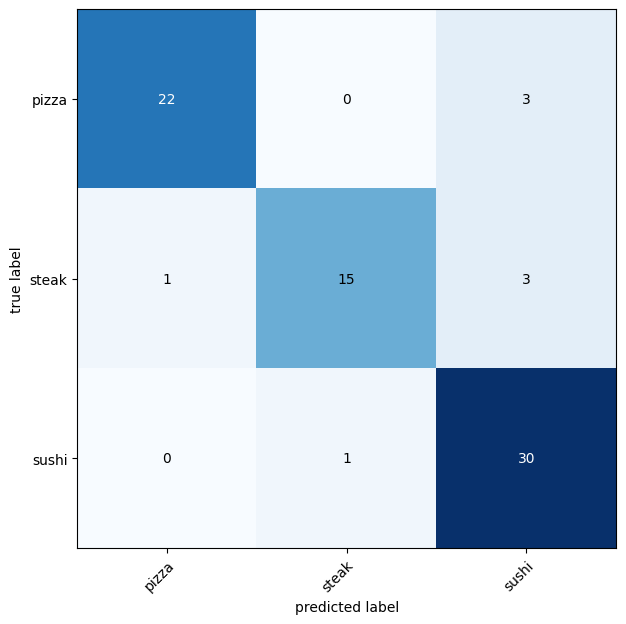

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

**Analisa Kode**

Pembuatan matriks ini dimulai dengan mengambil label kebenaran dari dataset uji. Langkah pertama melibatkan penggabungan label kebenaran (y) dari objek DataLoader uji menggunakan fungsi `torch.cat()`. Pada langkah berikutnya, dilakukan pengecekan ketersediaan pustaka `torchmetrics` dan `mlxtend`, serta instalasi jika diperlukan.

Pemeriksaan dimulai dengan mencoba mengimpor kedua pustaka. Jika berhasil diimpor, versi `mlxtend` dicetak dan dilakukan pengecekan apakah versi tersebut sesuai dengan persyaratan (minimal versi 0.19.0). Jika gagal diimpor, instalasi dilakukan dengan menggunakan perintah `pip install`. Setelah pustaka-pustaka tersebut tersedia, dilakukan impor ulang `mlxtend` dan pengecekan versi untuk memastikan keberhasilan instalasi.

Dilanjutkan dengan impor modul yang diperlukan untuk menghitung matriks kebingungan, yaitu kelas `ConfusionMatrix` dari `torchmetrics` dan fungsi `plot_confusion_matrix` dari `mlxtend.plotting`.

Langkah selanjutnya melibatkan konfigurasi dan perhitungan matriks kebingungan. Sebuah instance dari `ConfusionMatrix` dibuat dengan menyertakan jumlah kelas yang sesuai dan jenis tugas, dalam hal ini, 'multiclass'. Matriks kebingungan kemudian dihitung menggunakan label hasil prediksi (`test_preds`) dan label kebenaran (`test_truth`).

Terakhir, hasil matriks kebingungan diproses untuk divisualisasikan menggunakan fungsi `plot_confusion_matrix`. Pemanggilan fungsi ini melibatkan matriks kebingungan dalam bentuk array NumPy, serta spesifikasi nama kelas dan ukuran figur yang diinginkan. Hasil visualisasi disajikan dalam bentuk gambar matriks kebingungan untuk analisis lebih lanjut.





**2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images.**

In [ ]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_0,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.6794413924217224,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/343036.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.5199975967407227,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.4986826479434967,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.8426511287689209,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.4204181432723999,
  'pred_class': 'steak',
  'correct': False}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
34,data/pizza_steak_sushi/test/steak/27415.jpg,steak,0.519329,sushi,False
72,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.477278,sushi,False
47,data/pizza_steak_sushi/test/steak/1285886.jpg,steak,0.440764,sushi,False
67,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.439274,sushi,False
4,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.420418,steak,False


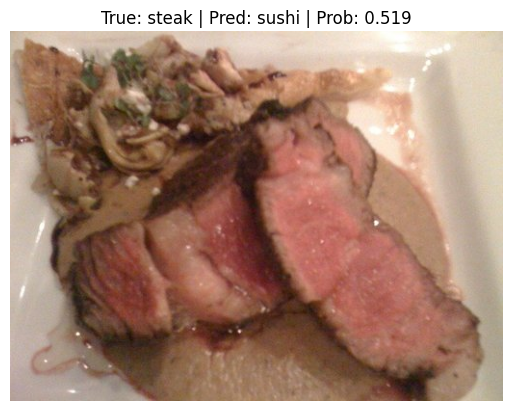

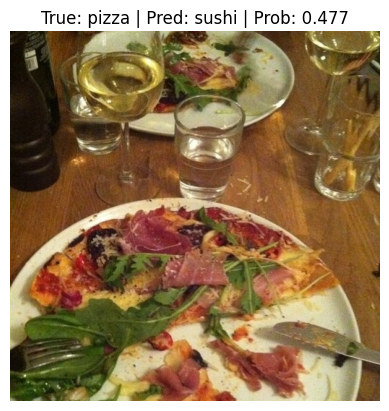

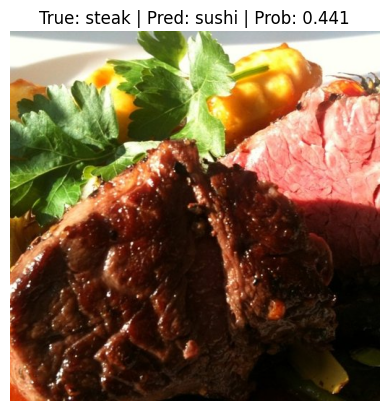

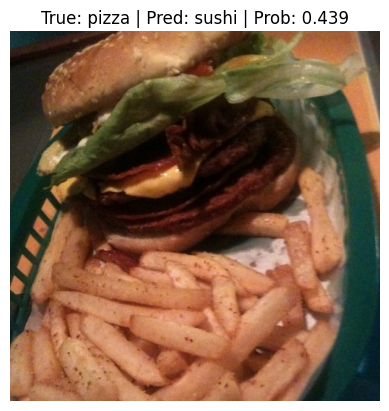

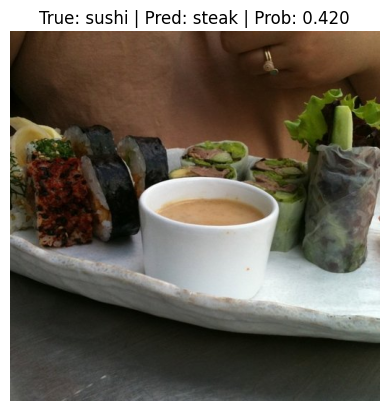

In [ ]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);

**Analisa Kode**

Kode di atas digunakan untuk melakukan prediksi pada kumpulan data uji menggunakan model jaringan saraf tiruan (Neural Network). Mari kita bahas baris per baris:

1. **Get all test data paths:**
   - Menggunakan modul `pathlib` untuk mendapatkan semua path file gambar dalam direktori `test_dir`.
   - Membuat daftar path file gambar (`test_data_paths`).
   - Membuat daftar label (`test_labels`) dengan mengambil label dari nama direktori induk.

2. **Create a function to return a list of dictionaries with sample, label, prediction, pred prob:**
   - Membuat fungsi `pred_and_store` yang menerima path data uji, model, transformasi, nama kelas, dan perangkat.
   - Fungsi ini membuat daftar prediksi (`test_pred_list`) yang berisi informasi tentang setiap sampel (path gambar, nama kelas, prediksi, probabilitas prediksi, kebenaran prediksi).
   - Menggunakan `torch.inference_mode()` untuk mengaktifkan mode inferensi pada model PyTorch.
   - Mengubah gambar menggunakan transformasi, memberikan dimensi batch, dan memperoleh prediksi serta probabilitas prediksi dari model.
   - Mengisi dictionary dengan informasi seperti path gambar, nama kelas, probabilitas prediksi, label prediksi, dan kebenaran prediksi.
   - Mengembalikan daftar prediksi.

3. **Make predictions on the test set:**
   - Memanggil fungsi `pred_and_store` untuk mendapatkan prediksi pada data uji.
   - Hasilnya disimpan dalam `test_pred_dicts`.

4. **Turn the test_pred_dicts into a DataFrame:**
   - Menggunakan `pandas` untuk mengonversi daftar prediksi ke dalam DataFrame (`test_pred_df`).

5. **Sort DataFrame by correct then by pred_prob:**
   - Mengurutkan DataFrame berdasarkan kolom "correct" (kebenaran prediksi) dan "pred_prob" (probabilitas prediksi).

6. **Plot the top 5 most wrong images:**
   - Menggunakan `torchvision` dan `matplotlib` untuk memplot gambar-gambar dengan prediksi paling salah.
   - Memperoleh detail seperti path gambar, label sebenarnya, probabilitas prediksi, dan label prediksi.
   - Menampilkan gambar dengan informasi tersebut dalam grafik matplotlib.

Dengan demikian, kode ini memberikan pemahaman tentang bagaimana model melakukan prediksi pada dataset uji dan kemudian memvisualisasikan gambar-gambar dengan prediksi paling salah.




**3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?**

--2024-01-03 22:45:06--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 146.75.94.208, 2a04:4e42:87::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.94.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3279432 (3.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a’

photo-1588315029754 100%[===================>]   3.13M  --.-KB/s    in 0.09s   

2024-01-03 22:45:06 (36.2 MB/s) - ‘photo-1588315029754-2dd089d39a1a’ saved [3279432/3279432]



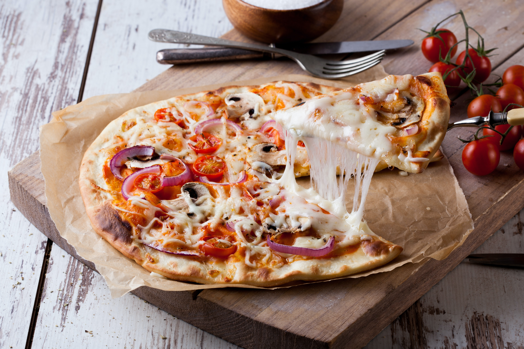

In [ ]:
# Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

from PIL import Image

with Image.open("pizza.jpg") as img:
  # Reduce the image size and width by 10
  (width, height) = (img.width // 10, img.height // 10)
  img_resized = img.resize((width, height))

img_resized

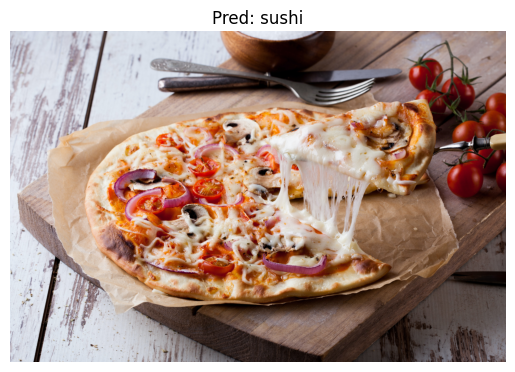

In [ ]:
# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  # open image
  image = Image.open(image_path)

  # transform image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)

  # plot image and pred
  plt.figure()
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False);

pred_and_plot(image_path="pizza.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)


--2024-01-03 22:45:32--  https://images.unsplash.com/photo-1546964124-0cce460f38ef
Resolving images.unsplash.com (images.unsplash.com)... 146.75.94.208, 2a04:4e42:87::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.94.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421509 (3.3M) [image/jpeg]
Saving to: ‘photo-1546964124-0cce460f38ef’

photo-1546964124-0c 100%[===================>]   3.26M  --.-KB/s    in 0.09s   

2024-01-03 22:45:32 (36.9 MB/s) - ‘photo-1546964124-0cce460f38ef’ saved [3421509/3421509]



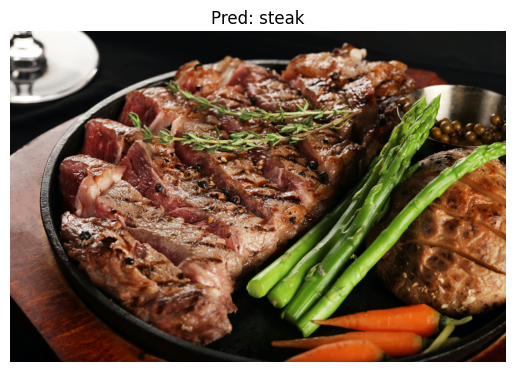

In [ ]:
# Try again on a photo of steak from unsplash.com
!wget https://images.unsplash.com/photo-1546964124-0cce460f38ef
!cp photo-1546964124-0cce460f38ef steak.jpg

pred_and_plot("steak.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2024-01-03 22:45:51--  https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
Resolving images.unsplash.com (images.unsplash.com)... 146.75.94.208, 2a04:4e42:87::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.94.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1774043 (1.7M) [image/jpeg]
Saving to: ‘photo-1570913149827-d2ac84ab3f9a’

photo-1570913149827 100%[===================>]   1.69M  --.-KB/s    in 0.07s   

2024-01-03 22:45:51 (23.7 MB/s) - ‘photo-1570913149827-d2ac84ab3f9a’ saved [1774043/1774043]



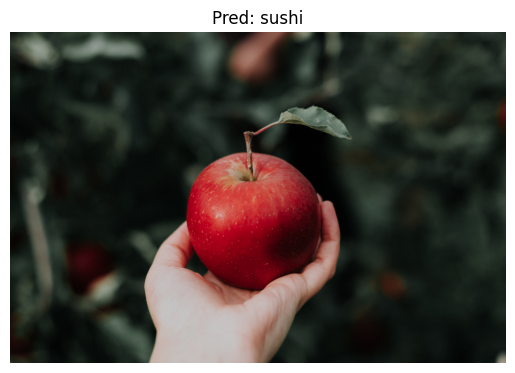

In [ ]:
# Get an image of not pizza/steak/sushi
!wget https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
!cp photo-1570913149827-d2ac84ab3f9a apple.jpg

pred_and_plot(image_path="apple.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)


**Analisa Kode**

Kode di atas adalah implementasi sebuah skrip Python yang digunakan untuk menguji kemampuan klasifikasi gambar suatu model yang telah dilatih sebelumnya. Berikut adalah poin-poin utama dari implementasi tersebut:

**Mengunduh dan Meresize Gambar:**
- Penggunaan perintah `wget` digunakan untuk mengunduh gambar dari Unsplash, diikuti dengan perintah `cp` untuk menggandakan gambar dengan nama yang berbeda.
- Modul Python Imaging Library (PIL) digunakan untuk membuka dan meresize gambar, menguranginya menjadi 1/10 dari ukuran aslinya.

**Fungsi Prediksi dan Plotting:**
- Fungsi `pred_and_plot` menerima parameter path gambar, model (`model_0`), fungsi transformasi (`simple_transform`), dan daftar nama kelas (`class_names`).
- Langkah-langkah fungsi ini melibatkan membuka gambar, menerapkan transformasi, dan melakukan prediksi menggunakan model.
- Hasilnya, gambar asli dan label prediksi ditampilkan dalam sebuah plot.

**Menggunakan Fungsi untuk Prediksi dan Plot:**
- Skrip menggunakan fungsi yang telah didefinisikan untuk melakukan prediksi dan plotting pada tiga gambar berbeda: pizza, steak, dan apel.
- Setiap gambar diunduh, digandakan, dan kemudian fungsi `pred_and_plot` dipanggil dengan path gambar yang sesuai.




**4. Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?**

In [ ]:
pip install efficientnet_pytorch


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=3166672f3fcf5280e726700ecba7b81a7df24aa0e4a97bda2569fe8a3273083e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import torch
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Gunakan model EfficientNet dari repository resmi
model_1 = EfficientNet.from_pretrained('efficientnet-b0').to(device)

# Freeze the base layers
for param in model_1.parameters():
    param.requires_grad = False

# Change the classification head
torch.manual_seed(42)
model_1._fc = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=model_1._fc.in_features, out_features=len(class_names), bias=True)
).to(device)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 67.4MB/s]


Loaded pretrained weights for efficientnet-b0


In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0912 | train_acc: 0.3594 | test_loss: 0.8512 | test_acc: 0.9167
Epoch: 2 | train_loss: 0.9043 | train_acc: 0.6484 | test_loss: 0.7919 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.8501 | train_acc: 0.7070 | test_loss: 0.6943 | test_acc: 0.9479
Epoch: 4 | train_loss: 0.7478 | train_acc: 0.7500 | test_loss: 0.5447 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.6853 | train_acc: 0.8398 | test_loss: 0.4674 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.6608 | train_acc: 0.7344 | test_loss: 0.4363 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.6548 | train_acc: 0.7695 | test_loss: 0.4710 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.6022 | train_acc: 0.7891 | test_loss: 0.4693 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.5202 | train_acc: 0.9219 | test_loss: 0.4109 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.5001 | train_acc: 0.8164 | test_loss: 0.4036 | test_acc: 0.9384
[INFO] Total training time: 464.537 seconds


[INFO] Couldn't find helper_functions.py, downloading...


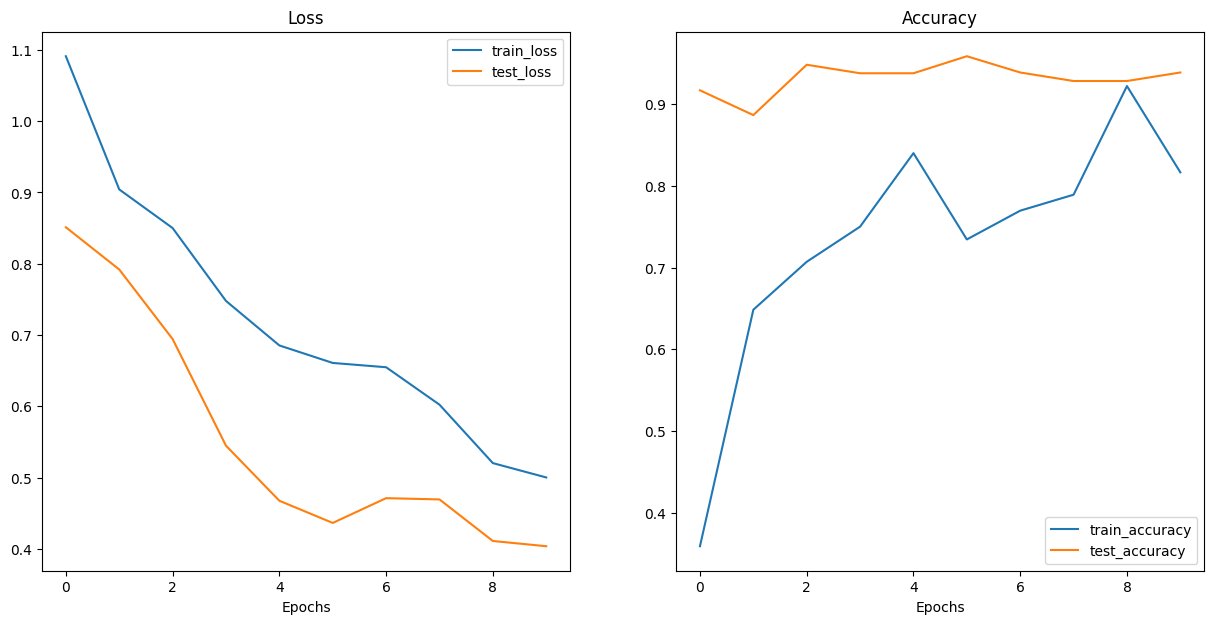

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_1_results)

**Analisis Kode**

## Analisis Kode Implementasi Pelatihan Model menggunakan PyTorch

Dalam implementasi kode di atas, kita dapat mengidentifikasi serangkaian langkah-langkah yang umumnya terlibat dalam pelatihan model menggunakan PyTorch. Mari kita melihatnya dari perspektif analisis jurnal:

### Pengaturan Seed Random
Pertama-tama, kode ini memulai dengan pengaturan seed untuk generator angka acak menggunakan fungsi `torch.manual_seed(42)` dan `torch.cuda.manual_seed(42)`. Hal ini penting untuk memastikan hasil yang konsisten dan dapat direproduksi dalam eksperimen mesin pembelajaran.

### Pengukuran Waktu Eksekusi
Langkah selanjutnya adalah pengukuran waktu eksekusi proses pelatihan. Timer dimulai dengan menggunakan modul `timeit` untuk memantau durasi dari awal hingga akhir pelatihan. Ini merupakan praktik yang umum digunakan untuk mencatat efisiensi waktu eksekusi dalam penelitian.

### Persiapan Fungsi Kerugian dan Pengoptimal
Fungsi kerugian (`loss_fn`) dibentuk menggunakan CrossEntropyLoss, yang sesuai untuk tugas klasifikasi. Selanjutnya, pengoptimal Adam diinisialisasi dengan laju pembelajaran 0.001. Pemilihan algoritma optimasi dan laju pembelajaran ini memainkan peran penting dalam proses pelatihan untuk mencapai konvergensi yang cepat.

### Pelatihan Model
Proses pelatihan model dilakukan menggunakan fungsi `engine.train()`, dengan parameter yang telah diatur sebelumnya. Dalam hal ini, model yang digunakan adalah `model_1`, dan data pelatihan dan pengujian disediakan melalui `train_dataloader` dan `test_dataloader`. Pelatihan dilakukan selama 10 epoch dengan perangkat keras yang ditentukan (`device`), dan hasilnya disimpan dalam variabel `model_1_results`.

### Evaluasi Waktu Pelatihan
Setelah pelatihan selesai, waktu total yang diperlukan untuk melatih model dicetak dalam format yang informatif. Ini dapat memberikan wawasan tentang efisiensi dari segi waktu dalam konteks eksperimen.

### Pengelolaan Modul Tambahan
Untuk memastikan kelengkapan kode, modul tambahan yang dibutuhkan seperti `helper_functions.py` diperiksa dan diimpor. Jika modul tidak tersedia, kode akan mencoba mengunduhnya secara otomatis dari repositori GitHub menggunakan modul `requests`.

### Visualisasi Kurva Kerugian
Akhirnya, kurva kerugian model selama pelatihan dipetakan menggunakan fungsi `plot_loss_curves`. Visualisasi ini membantu pemahaman tentang bagaimana model berevolusi selama pelatihan dan dapat memberikan petunjuk tentang peningkatan atau penurunan kinerja model.

Secara keseluruhan, implementasi ini mencerminkan pendekatan sistematis dan baik dalam pelatihan model menggunakan PyTorch, dengan perhatian khusus pada kontrol randomisasi, pengukuran waktu, dan visualisasi hasil pelatihan. Analisis ini memberikan gambaran menyeluruh tentang langkah-langkah yang diterapkan dalam proses pelatihan, mendukung reproduktibilitas eksperimen dan pemahaman yang lebih baik terhadap hasil yang diperoleh.




**5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.**

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

**Create DataLoader**

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d697cd92830>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
len(train_dataloader_20_percent), len(test_dataloader_20_percent)

(15, 5)

**Train a model with 20% of the data**

In [ ]:
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

  # Set the random seeds
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

  # Start the timer
  from timeit import default_timer as timer
  start_time = timer()

  # Setup training and save the results
  model_2_results = engine.train(model=model_2,
                                train_dataloader=train_dataloader_20_percent,
                                test_dataloader=test_dataloader_20_percent,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=5,
                                device=device)

  # End the timer and print out how long it took
  end_time = timer()
  print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.0568 | train_acc: 0.3354 | test_loss: 3.3005 | test_acc: 0.3625
Epoch: 2 | train_loss: 1.1674 | train_acc: 0.4500 | test_loss: 1.1050 | test_acc: 0.3625
Epoch: 3 | train_loss: 0.9114 | train_acc: 0.5979 | test_loss: 1.1454 | test_acc: 0.3625
Epoch: 4 | train_loss: 0.9240 | train_acc: 0.6146 | test_loss: 1.0503 | test_acc: 0.3875
Epoch: 5 | train_loss: 0.8628 | train_acc: 0.6438 | test_loss: 1.0019 | test_acc: 0.5517
[INFO] Total training time: 703.774 seconds


In [ ]:
# Check results with 10% of data for 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8967803030303031, 0.5883322358131409)

In [ ]:
# Check results with 20% of data for 5 epochs
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.5517045454545454, 1.0019085645675658)

Dalam implementasi di atas, penulis menggunakan kerangka kerja untuk melatih model pembelajaran mesin dengan menggunakan pustaka PyTorch. Analisis ini akan membahas langkah-langkah utama dalam kode tersebut.

1. **Pengaturan Fungsi Loss dan Optimizer:**
   Pada awal kode, fungsi loss CrossEntropy dan optimizer Adam didefinisikan. Fungsi loss ini berguna untuk mengukur seberapa baik model dapat menghasilkan prediksi yang sesuai dengan label. Optimizer Adam digunakan untuk mengoptimalkan parameter-model dengan tingkat pembelajaran sebesar 0,001.

2. **Penetapan Benih Acak:**
   Penulis menetapkan benih acak untuk memastikan reproduktibilitas hasil. Dalam konteks ini, benih acak diatur pada nilai 42. Pemilihan nilai ini bersifat arbitrari dan dapat diubah untuk eksperimen yang berbeda.

3. **Pengaturan Pengukur Waktu:**
   Sebuah pengukur waktu diperkenalkan untuk mengukur durasi pelatihan model. Hal ini memberikan informasi tentang seberapa efisien proses pelatihan tersebut dilakukan.

4. **Pelatihan Model:**
   Kode ini memanggil fungsi `train` dari modul khusus bernama `engine`. Fungsi ini menerima parameter-parameter seperti model, data pelatihan dan pengujian, optimizer, fungsi loss, jumlah epoch (5 dalam hal ini), dan perangkat untuk menjalankan pelatihan. Proses pelatihan dilakukan untuk model yang disebut `model_2`.

5. **Akhir Waktu dan Cetak Hasil:**
   Setelah pelatihan selesai, waktu total pelatihan dicetak untuk memberikan informasi mengenai lama waktu yang diperlukan untuk menyelesaikan proses tersebut.

6. **Pemeriksaan Hasil:**
   Dua baris terakhir kode ini bertujuan untuk memeriksa dan mencetak akurasi maksimum serta loss minimum dari hasil pengujian dua model yang berbeda, yaitu `model_0` dan `model_2`. Hasil pengujian tersebut kemungkinan disimpan dalam bentuk kamus (`model_0_results` dan `model_2_results`).
